In [327]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
torch.manual_seed(0)

# labels for multi-class classification task
CIRCLE = 0
EQ_TRIANGLE = 1
SQUARE = 2
ELLIPSE = 3
RECTANGLE = 4
NON_EQ_TRIANGLE = 5

In [328]:
def shape_label(shape_type):
    """
    """    
    if shape_type == 'circle':
        shape_type = CIRCLE
    elif shape_type == 'ellipse':
        shape_type = ELLIPSE
    elif shape_type == 'square':
        shape_type = SQUARE
    elif shape_type == 'rectangle':
        shape_type = RECTANGLE
    elif shape_type == 'eq_triangle':
        shape_type = EQ_TRIANGLE
    else:
        shape_type = NON_EQ_TRIANGLE
    
    return shape_type

def generate_eq_triangle(image_size):

    triangle_height = np.random.randint(image_size // 4, image_size // 2)
    x1 = np.random.randint(0, image_size - triangle_height)
    y1 = np.random.randint(0, image_size - triangle_height)
    x2 = x1 + triangle_height
    y2 = y1
    x3 = x1 + (triangle_height // 2)
    y3 = y1 + triangle_height
    pts = np.array([[x1, y1], [x2, y2], [x3, y3]], np.int32)
    return pts
    

def generate_non_eq_triangle(image_size):
    side_a = np.random.randint(image_size // 4, image_size // 2)
    side_b = np.random.randint(image_size // 4, image_size // 2)
    side_c = np.random.randint(image_size // 4, image_size // 2)

    while not (side_a + side_b > side_c and side_b + side_c > side_a and side_a + side_c > side_b):
        side_a = np.random.randint(image_size // 4, image_size // 2)
        side_b = np.random.randint(image_size // 4, image_size // 2)
        side_c = np.random.randint(image_size // 4, image_size // 2)

    while side_a == side_b or side_b == side_c or side_a == side_c:
        side_a = np.random.randint(image_size // 4, image_size // 2)
        side_b = np.random.randint(image_size // 4, image_size // 2)
        side_c = np.random.randint(image_size // 4, image_size // 2)

    x1 = np.random.randint(0, image_size - side_a - 1)
    y1 = np.random.randint(0, image_size - side_b - 1)
    x2 = x1 + side_a
    y2 = y1
    x3 = np.random.randint(x1 + side_b, x1 + side_a + side_c)
    y3 = y1 + side_b

    pts = np.array([[x1, y1], [x2, y2], [x3, y3]], np.int32)

    return pts


def generate_shape(image_size, complex=False):

    # add more complicated shapes for complex dataset
    shape_type = np.random.choice(
        ['rectangle', 'ellipse', 'non_eq_triangle']) if complex else np.random.choice(['square', 'circle', 'eq_triangle'])
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    if shape_type == 'square':
        side_length = np.random.randint(image_size // 4, image_size // 2)
        x = np.random.randint(0, image_size - side_length)
        y = np.random.randint(0, image_size - side_length)
        image[y:y+side_length, x:x+side_length] = 255

    elif shape_type == 'circle':
        radius = np.random.randint(image_size // 8, image_size // 4)
        center_x = np.random.randint(radius, image_size - radius)
        center_y = np.random.randint(radius, image_size - radius)
        cv2.circle(image, (center_x, center_y), radius, 255, -1)

    elif shape_type == 'rectangle':
        width = np.random.randint(image_size // 4, image_size // 2)
        height = np.random.randint(image_size // 4, image_size // 2)
        x = np.random.randint(0, image_size - width)
        y = np.random.randint(0, image_size - height)
        image[y:y+height, x:x+width] = 255

    elif shape_type == 'ellipse':
        major_axis = np.random.randint(image_size // 4, image_size // 2)
        minor_axis = np.random.randint(image_size // 4, image_size // 2)
        center_x = np.random.randint(major_axis, image_size - major_axis)
        center_y = np.random.randint(minor_axis, image_size - minor_axis)
        cv2.ellipse(image, (center_x, center_y),
                    (major_axis, minor_axis), 0, 0, 360, 255, -1)

    elif shape_type == 'eq_triangle':
        pts = generate_eq_triangle(image_size)
        cv2.fillPoly(image, [pts], 255)

    elif shape_type == 'non_eq_triangle':
        pts = generate_non_eq_triangle(image_size)
        cv2.fillPoly(image, [pts], 255)

    return image.astype(np.float32), shape_type

In [329]:
def generate_shape_dataset(num_examples, image_size, complex=False):

    dataset, labels = [], []
    for _ in range(num_examples):
        shape_image, shape_type = generate_shape(image_size, complex=complex)
        shape_type = shape_label(shape_type)
        dataset.append(shape_image)
        labels.append(shape_type)

    return tensor(dataset, dtype=torch.float32), tensor(labels, dtype=torch.long)

# example distribution: 10000 train, 5000 validation, 5000 test
dataset_size = 20000
image_size = 32

dataset_basic, labels_basic = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=False)
dataset_complex, labels_complex = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=True)

# we only want total number of examples to be 20000; ensure distribution of basic and complex examples is 50-50
dataset_combined = torch.cat((dataset_basic[:dataset_size//2], dataset_complex[:dataset_size//2]), dim=0)
labels_combined = torch.cat((labels_basic[:dataset_size//2], labels_complex[:dataset_size//2]), dim=0)

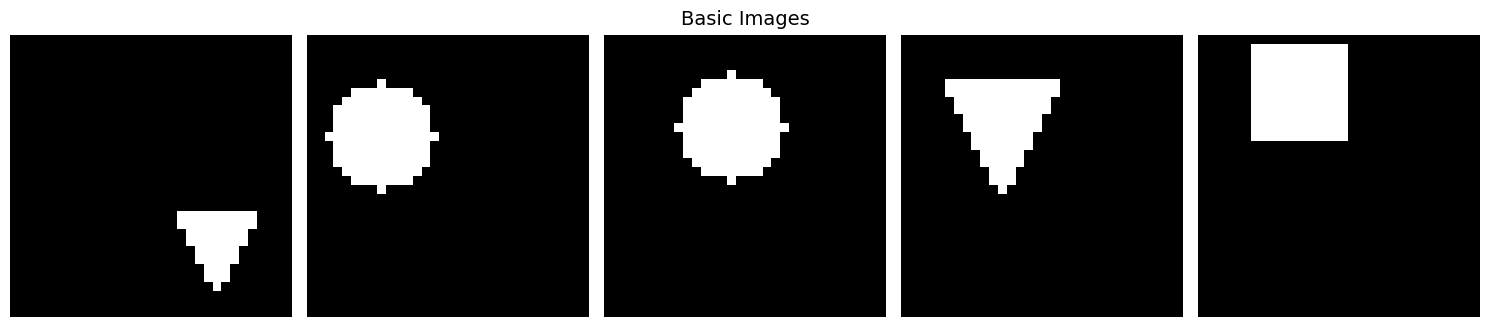

In [330]:
# visualize a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_basic[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Basic Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

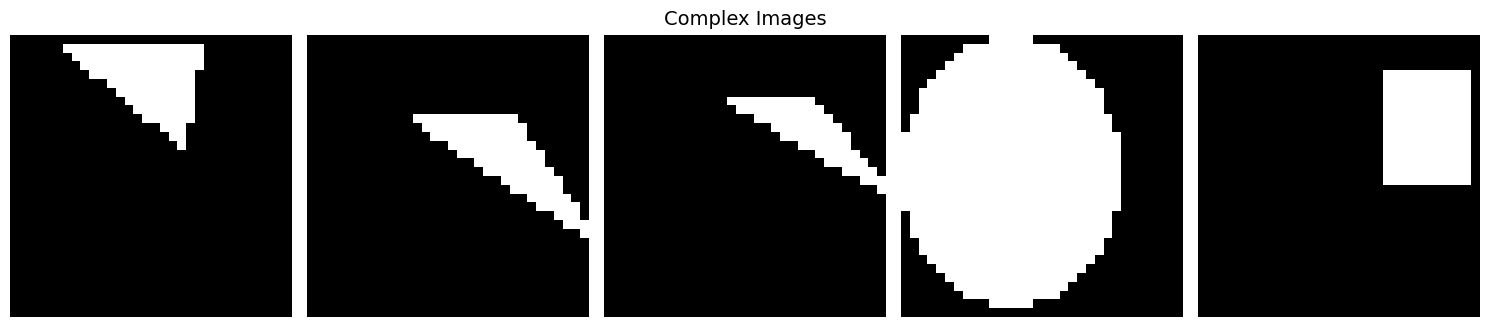

In [331]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_complex[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Complex Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

In [332]:
class ShapeDataset(Dataset):
    def __init__(self, dataset, labels, num_classes):
        self.data = dataset
        self.labels = labels
        self.num_classes = num_classes
        self.num_samples = dataset.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


def prepare_data(dataset, labels, batch_size, num_classes, shuffle=False):

    X_train, X_test, y_train, y_test = train_test_split(dataset, labels,
                                                        train_size=0.5, test_size=0.5)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                    train_size=0.5, test_size=0.5)

    train_dataset = ShapeDataset(
        dataset=X_train, labels=y_train, num_classes=num_classes)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)

    val_dataset = ShapeDataset(
        dataset=X_val, labels=y_val, num_classes=num_classes)
    val_loader = DataLoader(
        dataset=val_dataset, batch_size=batch_size, shuffle=shuffle)

    test_dataset = ShapeDataset(
        dataset=X_test, labels=y_test, num_classes=num_classes)
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader, test_loader

num_classes = 6
batch_size = 100

train_loader_basic, val_loader_basic, test_loader_basic = prepare_data(
    dataset=dataset_basic, labels=labels_basic, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_complex, val_loader_complex, test_loader_complex = prepare_data(
    dataset=dataset_complex, labels=labels_complex, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_combined, val_loader_combined, test_loader_combined = prepare_data(
    dataset=dataset_combined, labels=labels_combined, batch_size=batch_size, num_classes=num_classes, shuffle=True)

In [362]:
from torch.nn.functional import tanh, softmax

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = tanh(self.layer1(x))
        x = tanh(self.layer2(x))
        x = softmax(self.layer3(x), dim=-1, dtype=torch.float32)
        return x

def train_epoch(model, loader, loss_fn, optimizer, epoch, num_epochs=256):

    model.train()
    total, num_correct = 0, 0
    for images, labels in tqdm(loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        
        images = images.view(images.size(0), -1)  # flatten images
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # make prediction by choosing most likely outcome
        predictions = torch.argmax(outputs, dim=-1)

        # keep tabs on accuracy score
        num_correct += (predictions == labels).sum().item()
        total += labels.shape[0]

    return num_correct / total

def train_model(model, loader, loss_fn, optimizer, num_epochs=256, verbose=False, tol=1-(1e-6), val_loader=None, switch_loader=None, switch_epoch=None, model_type='basic'):
    best_acc = float('-inf')
    switched = False
    for epoch in range(num_epochs):

        if switch_epoch is not None and epoch >= switch_epoch:
            if not switched:
                switched = True
                print("Curriculum training on basic data complete. Now training curriculum model on complex data...")
            train_acc = train_epoch(model, switch_loader, loss_fn, optimizer, epoch, num_epochs)
        else:
            train_acc = train_epoch(model, loader, loss_fn, optimizer, epoch, num_epochs)
    
        if verbose:
            print(f'Epoch {epoch + 1}, Training Accuracy: {train_acc}')
        
        val_acc = eval_model(model, val_loader, model_type=model_type, data_type='validation')
        best_acc = val_acc if val_acc > best_acc else best_acc

        # early exit based on validation accuracy
        if best_acc > tol:
            break

    print(f"Model validation accuracy after training: {best_acc}")
    return model, best_acc


def eval_model(model, loader, model_type='basic', data_type='test', verbose=False):
    model.eval()
    total, num_correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1)  # flatten images
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=-1)
            num_correct += (predictions == labels).sum().item()
            total += labels.shape[0]
    acc = num_correct/total
    if verbose:
        print(f"{model_type} {data_type} accuracy: {num_correct/total}")
    return acc

In [349]:
def grid_search(param_grid, loader, input_size, output_size=6, val_loader=None):

    best_params = None
    best_acc = float('-inf')

    for hidden_size in param_grid['hidden_sizes']:
        for learning_rate in param_grid['learning_rates']:
            print(
                f'Training with learning rate={learning_rate} and hidden size={hidden_size}')
            model = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()
            model, _ = train_model(model, loader, criterion, optimizer, val_loader=val_loader, model_type='complex')

            val_acc = eval_model(model, val_loader, model_type='complex', data_type='validation')
            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {'hidden_size' : hidden_size, 'learning_rate' : learning_rate}
    
    return best_params, best_acc

In [350]:
input_size = image_size * image_size
output_size = 6

# Hyperparameters to tune
param_grid = {
    'hidden_sizes': [32, 64, 128, 256],
    'learning_rates' : [0.001, 0.01, 0.1]
}

best_params, best_acc = grid_search(param_grid, train_loader_complex, input_size=input_size, val_loader=val_loader_complex)

Training with learning rate=0.001 and hidden size=32


Model accuracy after training: 0.9402
Training with learning rate=0.01 and hidden size=32


Model accuracy after training: 0.8154
Training with learning rate=0.1 and hidden size=32


Model accuracy after training: 0.742
Training with learning rate=0.001 and hidden size=64


Model accuracy after training: 0.9698
Training with learning rate=0.01 and hidden size=64


Model accuracy after training: 0.8488
Training with learning rate=0.1 and hidden size=64


Model accuracy after training: 0.337
Training with learning rate=0.001 and hidden size=128


Model accuracy after training: 0.9776
Training with learning rate=0.01 and hidden size=128


Model accuracy after training: 0.9218
Training with learning rate=0.1 and hidden size=128


Model accuracy after training: 0.337
Training with learning rate=0.001 and hidden size=256


Model accuracy after training: 0.9792
Training with learning rate=0.01 and hidden size=256


Model accuracy after training: 0.9312
Training with learning rate=0.1 and hidden size=256


Model accuracy after training: 0.3248
Optimal hyperparameters selected by maximizing complex validation accuracy.
Hidden layer size: 128
Learning rate: 0.001


In [312]:
hidden_size = best_params['hidden_size']
learning_rate = best_params['learning_rate']
ce_loss = nn.CrossEntropyLoss()
num_epochs = 256

print("Optimal hyperparameters selected by maximizing complex validation accuracy.")
print(f"Hidden layer size: {hidden_size}")
print(f"Learning rate: {learning_rate}")

In [351]:
model_basic = FeedForward(input_size=input_size,
                          hidden_size=hidden_size, output_size=output_size)

optimizer_basic = optim.Adam(model_basic.parameters(), lr=learning_rate)

print("Training basic model on basic data...")
model_basic, _ = train_model(model=model_basic, loader=train_loader_basic,
                          loss_fn=ce_loss, optimizer=optimizer_basic, num_epochs=num_epochs,
                          verbose=False, val_loader=val_loader_basic)
print("Basic data training complete for basic model!")

Training basic model on basic data...


Model accuracy after training: 0.7888
Basic data training complete for basic model!


In [364]:
model_curriculum = FeedForward(input_size=input_size,
                               hidden_size=hidden_size, output_size=output_size)

optimizer_curriculum = optim.Adam(
    model_curriculum.parameters(), lr=learning_rate)

# train the curriculum model on the basic dataset first, then the complex one
print("Training curriculum models...")

curriculum_models = []
currciulum_accs = []
for i in range(0, 7 + 1):
    switch_epoch = 0 if i == 0 else 2**i
    print(f'Training curriculum model at switch epoch={switch_epoch}')
    model, acc = train_model(model=model_curriculum, loader=train_loader_basic,
                        loss_fn=ce_loss, optimizer=optimizer_curriculum, 
                        num_epochs=num_epochs, verbose=False, 
                        switch_loader=train_loader_complex,
                        val_loader=val_loader_complex,
                        switch_epoch=switch_epoch)
    curriculum_models.append(model) # curriculum model at index i is trained at switch_epoch 2 ** i
    currciulum_accs.append(acc)

    print(f"Validation accuracy of model at switch epoch {switch_epoch}: {acc}")

print("All curriculum models completed training!")

Training curriculum models...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9776
Validation accuracy of model at switch epoch 0: 0.9776
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9826
Validation accuracy of model at switch epoch 2: 0.9826
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9796
Validation accuracy of model at switch epoch 4: 0.9796
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.978
Validation accuracy of model at switch epoch 8: 0.978
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9752
Validation accuracy of model at switch epoch 16: 0.9752
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9738
Validation accuracy of model at switch epoch 32: 0.9738
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9772
Validation accuracy of model at switch epoch 64: 0.9772
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model validation accuracy after training: 0.9704
Validation accuracy of model at switch epoch 128: 0.9704
All curriculum models completed training!


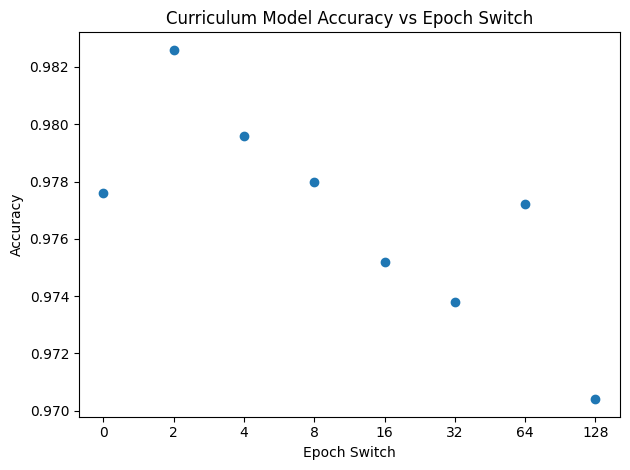

In [370]:
x_indices = list(range(8))
switch_epochs = [0] + [2**i for i in range(1, 8)]
plt.plot(x_indices, currciulum_accs, marker='o', linestyle='None')
plt.xlabel('Epoch Switch')
plt.ylabel('Accuracy')
plt.title('Curriculum Model Accuracy vs Epoch Switch')
plt.xticks(x_indices, switch_epochs)
plt.tight_layout()
plt.show()

In [376]:
model_complex = FeedForward(input_size=input_size,
                            hidden_size=hidden_size, output_size=output_size)

optimizer_complex = optim.Adam(model_complex.parameters(), lr=learning_rate)

print("Training complex model on complex data...")

model_complex, _ = train_model(model=model_complex, loader=train_loader_complex,
                         loss_fn=ce_loss, optimizer=optimizer_complex, num_epochs=num_epochs,
                         val_loader=val_loader_complex, verbose=False)

print("Complex data training complete for complex model!")

Training complex model on complex data...


Model validation accuracy after training: 0.9748
Complex data training complete for complex model!


In [377]:
model_combined = FeedForward(input_size=input_size,
                             hidden_size=hidden_size, output_size=output_size)

optimizer_combined = optim.Adam(
    model_combined.parameters(), lr=learning_rate)

print("Training combined model on all data...")

model_combined, _ = train_model(model=model_combined, loader=train_loader_combined,
                             loss_fn=ce_loss, optimizer=optimizer_combined, num_epochs=num_epochs,
                             val_loader=val_loader_combined, verbose=False)

print("Combined data training complete on combined model!")

Training combined model on all data...


Model validation accuracy after training: 0.671
Combined data training complete on combined model!


In [379]:
# base model performance on combined data
basic_test_acc = eval_model(model=model_basic, loader=val_loader_combined, model_type='basic', verbose=True)
curriculum_test_acc = eval_model(model=model_curriculum, loader=val_loader_combined, model_type='curriculum', verbose=True)
complex_test_acc = eval_model(model=model_complex, loader=val_loader_combined, model_type='complex', verbose=True)
combined_test_acc = eval_model(model=model_combined, loader=val_loader_combined, model_type='combined', verbose=True)

basic test accuracy: 0.41
curriculum test accuracy: 0.488
complex test accuracy: 0.4888
combined test accuracy: 0.6692
